# MVRegFus: Stitching

Notebook to test stitching / tiling of many tif stacks.

- Create test data
- Write to tifs
- Run registration and fusion

In [1]:
%matplotlib widget
import mvregfus
from mvregfus import multiview
import matplotlib.pyplot as plt

import numpy as np
import os
from scipy import ndimage
from dask import array as da
import tifffile

In [2]:
from pathlib import Path
import numpy as np
from aicsimageio import AICSImage
from aicspylibczi import CziFile

# files = [
# '/home/malbert/projects/stitching/data/WT_emb2_20X_part1_Scene-2-TR3.czi',
# '/mnt/gaia/gros_stitching_project/arthur_20220621_premovie_dish2-max.czi',
# # '/mnt/gaia/gros_stitching_project/arthur_20220609_WT_emb2_5X_part1_max.czi',
# ]

base_dir = '/mnt/data/projects/stitching_project'
files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('czi')]
files

['/mnt/data/projects/stitching_project/arthur_20220105_01_motorized_stretch-01.czi',
 '/mnt/data/projects/stitching_project/arthur_20220609_WT_emb2_5X_part1_max.czi',
 '/mnt/data/projects/stitching_project/yu_220721_ultra-TAG_st7_dorsal_x5_zoom0.7_1x2_5min_10.czi',
 '/mnt/data/projects/stitching_project/yu_220829_WT_quail_st4+_x40_zoom0.5_5x5_488ZO1-568Sox2-647Tbra.czi',
 '/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi',
 '/mnt/data/projects/stitching_project/arthur_20220621_premovie_dish2-max.czi']

In [4]:
filename = files[4]
out_dir = filename[:-4]+'_out_3d'
print(filename)
print(out_dir)
[f for f in os.listdir(out_dir)]# if f.startswith('mv_tr')]

/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi
/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra_out_3d


['mv_params_000_000_vfix000_vmov001.prealignment.h5',
 'mv_params_000_000_vfix001_vmov002.prealignment.h5',
 'mv_params0_000_000.prealignment.h5',
 'mv_stack_props_000_000.dict.h5',
 'mv_transf_view_000_000_v001_c00.image.ims',
 'mv_transf_view_000_000_v000_c00.image.ims',
 'mv_transf_view_000_000_v002_c00.image.ims',
 'mv_transf_view_000_000_v000_c01.image.ims',
 'mv_transf_view_000_000_v001_c01.image.ims',
 'mv_transf_view_000_000_v002_c01.image.ims',
 'mv_transf_view_000_000_v000_c02.image.ims',
 'mv_transf_view_000_000_v001_c02.image.ims',
 'mv_transf_view_000_000_v002_c02.image.ims',
 'mv_000_000_c00.ims',
 'mv_000_000_c01.ims',
 'mv_000_000_c02.ims']

In [5]:
# rm /mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra_out_2d/mv_*

In [80]:
ls /mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra_out_2d

mv_params0_000_000.prealignment.h5
mv_params_000_000_vfix000_vmov001.prealignment.h5
mv_params_000_000_vfix001_vmov002.prealignment.h5
mv_stack_props_000_000.dict.h5
mv_transf_view_000_000_v000_c00.image.ims
mv_transf_view_000_000_v000_c01.image.ims
mv_transf_view_000_000_v000_c02.image.ims
mv_transf_view_000_000_v001_c00.image.ims
mv_transf_view_000_000_v001_c01.image.ims
mv_transf_view_000_000_v001_c02.image.ims
mv_transf_view_000_000_v002_c00.image.ims
mv_transf_view_000_000_v002_c01.image.ims
mv_transf_view_000_000_v002_c02.image.ims


In [6]:
import importlib
from mvregfus import mv_graph, io_utils, mv_utils

io_utils = importlib.reload(io_utils)
filename = files[4]
view_dict = io_utils.build_view_dict_from_multitile_czi(filename, max_project=True)

http://localhost:8787
]0;multi-view fusion: http://localhost:8787

In [16]:
# %%capture

from mvregfus import mv_graph, io_utils, mv_utils
import os

from aicsimageio import AICSImage
from aicspylibczi import CziFile

import importlib
mv_graph = importlib.reload(mv_graph)
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)
multiview = importlib.reload(multiview)

for filename in [files[4]]:
# for filename in files:
    # try:

    from aicspylibczi import CziFile
    aicspylibcziFile = CziFile(filename)
    dims = aicspylibcziFile.get_dims_shape()[0]

    # times = range(dims['T'][0], dims['T'][1])[:]
    times = range(1)
    channels = range(dims['C'][0], dims['C'][1])
    multitile_czi_sample = 0
    multitile_czi_z_project = True
    
    view_dict = io_utils.build_view_dict_from_multitile_czi(filename, max_project=multitile_czi_z_project)
    pairs = mv_utils.get_registration_pairs_from_view_dict(view_dict)
    # pairs = [(0,5)]
    ndim = len(view_dict[0]['shape'])

    graph = {}
    for t in times:

        outdir = filename[:-4]+'_out_2d'
        if not os.path.exists(outdir): os.makedirs(outdir)
        # outdir = '/tmp'

        # build dask graph
        graph.update(
            mvregfus.mv_graph.build_multiview_graph(
                out_dir=outdir,
                ndim=ndim,
                filepath=None,
                channels=channels,
                reg_channel=0,
                perform_chromatic_correction=False,
                mv_registration_bin_factors=[2]*ndim,
                mv_final_spacing=view_dict[0]['spacing'],
                pairs=pairs,
                view_dict=view_dict,
                fusion_method='weighted_average',
                fusion_weights='blending',
                elastix_dir='/home/malbert/software/elastix',
                pairwise_registration_mode=None, # 0: translation registration using elastix
                final_volume_mode='union',
                debug_pairwise_registration=True,
                background_level=0,
                sample=t,
                time_alignment=False,
                time_alignment_ref_view=0,
                multitile_czi=True,
                multitile_czi_sample=multitile_czi_sample,
                multitile_czi_z_project=multitile_czi_z_project,
            )
        )

    # compute dask graph
    # keys = [k for k in graph.keys() if k.startswith('mv_transf')]
    keys = [mv_graph.multiview_fused_label %(0, s, ch) for s in times for ch in channels]
    # keys = [k for k in graph.keys() if k.startswith('view_full')]
    fs = io_utils.get(graph, keys, local=True)
        
    # except:
    #     pass

http://localhost:43549
]0;multi-view fusion: http://localhost:43549These pairs of keys will be registered:
array([[0, 1],
       [1, 2]])
They refer to the keys in 'view_dict':
{0: {'filename': '/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi',
     'origin': array([0., 0.]),
     'rotation': 0,
     'shape': array([1024, 1024]),
     'spacing': array([1., 1.]),
     'view': 0},
 1: {'filename': '/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi',
     'origin': array([1024.,    0.]),
     'rotation': 0,
     'shape': array([1024, 1024]),
     'spacing': array([1., 1.]),
     'view': 1},
 2: {'filename': '/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi',
     'origin': array([2048.,    0.]),
     'rotation': 0,
     'shape': array([1024, 1024]),
     'spacing': array([1., 1.]),
     'view': 2}}
Skipping groupwise registrati

/home/malbert/miniconda3/envs/mvregfus/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43549 instead
  warnings.warn(


In [17]:
import dask
f = dask.compute(fs, scheduler='single-threaded')

/home/malbert/miniconda3/envs/mvregfus/lib/python3.9/site-packages/dask/base.py:1366: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


In [22]:
f[0][0]

array([[12, 13, 15, ...,  7,  9,  7],
       [11, 14, 14, ...,  8,  7,  8],
       [11,  9, 11, ...,  5,  6,  7],
       ...,
       [19, 10, 10, ..., 12,  8, 10],
       [21, 12, 14, ..., 10,  8,  9],
       [16, 12, 13, ...,  9,  8,  8]], dtype=uint8)

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f166410b370>)

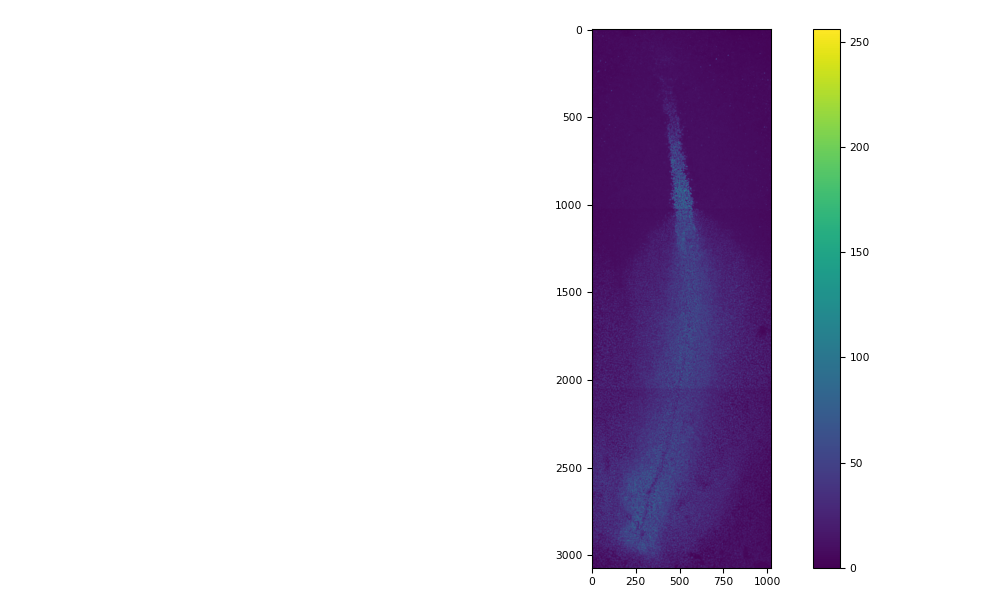

In [25]:
tifffile.imshow(f[0][2])

In [39]:
view_dict = io_utils.build_view_dict_from_multitile_czi(filename)
pairs = mv_utils.get_registration_pairs_from_view_dict(view_dict)
pairs

array([[0, 1],
       [1, 2]])

In [8]:
filename = files[1]
print(filename)
outdir = filename[:-4]+'_out2'
print(outdir)

/mnt/data/projects/stitching_project/arthur_20220609_WT_emb2_5X_part1_max.czi
/mnt/data/projects/stitching_project/arthur_20220609_WT_emb2_5X_part1_max_out2


In [9]:
ls /mnt/data/projects/stitching_project/arthur_20220609_WT_emb2_5X_part1_max_out2

In [42]:
chs

range(0, 3)

/mnt/data/projects/stitching_project/yu_220829_WT_quail_st6_x10_zoom0.7_1x3_488ZO1-568Sox2-647Tbra.czi


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


(<Figure size 988.8x604.8 with 5 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fa4f84e45e0>)

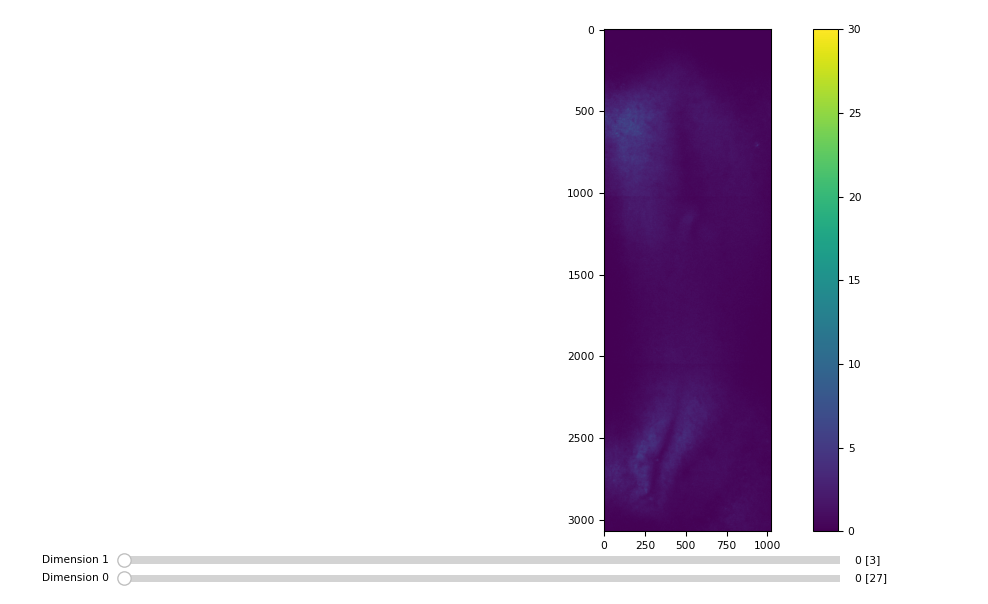

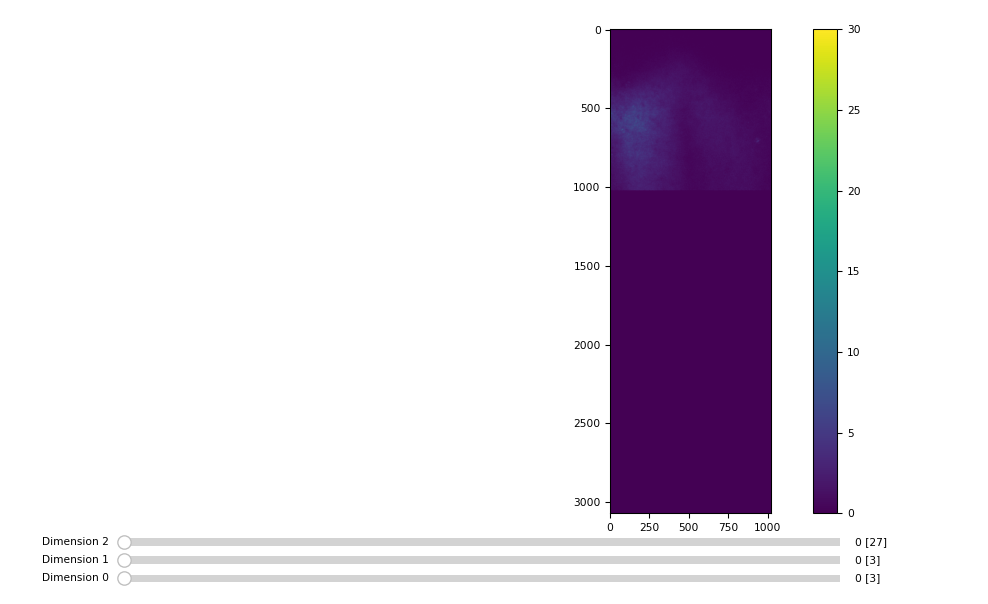

In [65]:
imt, imss = [], []
from tqdm import tqdm
import h5py, os

from mvregfus import mv_utils, io_utils

filename = files[4]
print(filename)
outdir = filename[:-4]+'_out_3d'

from aicspylibczi import CziFile
aicspylibcziFile = CziFile(filename)
dims = aicspylibcziFile.get_dims_shape()[0]

times = range(1)
# times = range(dims['T'][0], dims['T'][1])
chs = range(dims['C'][0], dims['C'][1])
views = range(dims['M'][0], dims['M'][1])

shapes = np.array([io_utils.process_input_element(os.path.join(outdir,
                'mv_stack_props_000_%03d.dict.h5' %(t)))['size'] for t in times])

max_shape = np.max(shapes, 0)
# min_shape = 

for t in tqdm(times):
# for t in times:
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in views]
        # fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in [0, 1,6,7]]

        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        # w_blending_only_one = mv_utils.get_sigmoidal_border_weights_ndim_only_one(ims, width=10)
        # wsum = np.sum(w_blending_only_one, axis=0)
        # wsum[wsum==0] = 1
        # im = np.sum([w*im for w, im in zip(w_blending_only_one, ims)], axis=0)
        # im /= wsum
        
        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        
        im = np.pad(im, [[0, max_shape[dim] - im.shape[dim]] for dim in range(im.ndim)])
        
        # # tim.append(im)
        
        imt.append(np.array(im))
        
        ims = np.array([np.pad(i, [[0, max_shape[dim] - i.shape[dim]] for dim in range(i.ndim)]) for i in ims])
        imss.append(ims)
        # print(im.shape)
        # min_shape = np.min([min_shape, im.shape],0)

# imt = np.array([np.pad(i, [[0, max_shape[dim] - i.shape[dim]] for dim in range(i.ndim)]) for i in imt])
imt = np.array(imt)
imss = np.array(imss)
# imt = np.array([i[:min_shape[0], :min_shape[1]] for i in imt])
# imss = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imss])

imt = imt.reshape([len(times), len(chs)] + list(im.shape))#.swapaxes(1,2)
if im.ndim == 3:
    imt = imt.swapaxes(1,2)
    axes = 'TZCYX'
else:
    axes = 'TCYX'
imss = imss.reshape([len(times), len(chs), len(views)] + list(im.shape))#.swapaxes(1,2)

# imss = imss.reshape((len(times), len(chs), imss.shape[-3], imss.shape[-2], imss.shape[-1])).swapaxes(1,2)

out_file = filename[:-4]+'_reconstructed_3dtp0.tif'
tifffile.imwrite(out_file, imt.astype(np.uint16), imagej=True, metadata={'axes':axes})

tifffile.imshow(imt, vmin=0, vmax=30, photometric='la')
tifffile.imshow(np.array(imss), vmin=0, vmax=30, photometric='la')

In [51]:
imt = imt.reshape([len(times), len(chs)] + list(im.shape))#.swapaxes(1,2)
if im.ndim == 3:
    imt = imt.swapaxes(1,2)
    axes = 'TZCYX'
else:
    axes = 'TCYX'

In [52]:
out_file = filename[:-4]+'_reconstructed_3d_tp0.tif'
tifffile.imwrite(out_file, imt.astype(np.uint16), imagej=True, metadata={'axes':'TZCYX'})

In [44]:
imss = imss.reshape([len(times), len(chs), len(views)] + list(im.shape)).swapaxes(1,2)


In [42]:
im.shape

(28, 3914, 2054)

In [35]:
ls /mnt/data/projects/stitching_project/yu_220721_ultra-TAG_st7_dorsal_x5_zoom0.7_1x2_5min_10_out_3d

mv_params0_000_000.prealignment.h5
mv_params_000_000_vfix000_vmov001.prealignment.h5
mv_reginfo_000_000_pair_0_1_view_0.tif
mv_reginfo_000_000_pair_0_1_view_1.tif
mv_reginfo_000_000_pair_0_1_view_1_pretransformed.tif
mv_stack_props_000_000.dict.h5
mv_transf_view_000_000_v000_c00.image.ims
mv_transf_view_000_000_v001_c00.image.ims


In [14]:
out_file = filename[:-4]+'_reconstructed_tp0.tif'
out_file

'/mnt/data/projects/stitching_project/arthur_20220609_WT_emb2_5X_part1_max_reconstructed_tp0.tif'

In [454]:
imt2 = np.copy(imt)

(<Figure size 988.8x604.8 with 4 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7efd4d0190a0>)

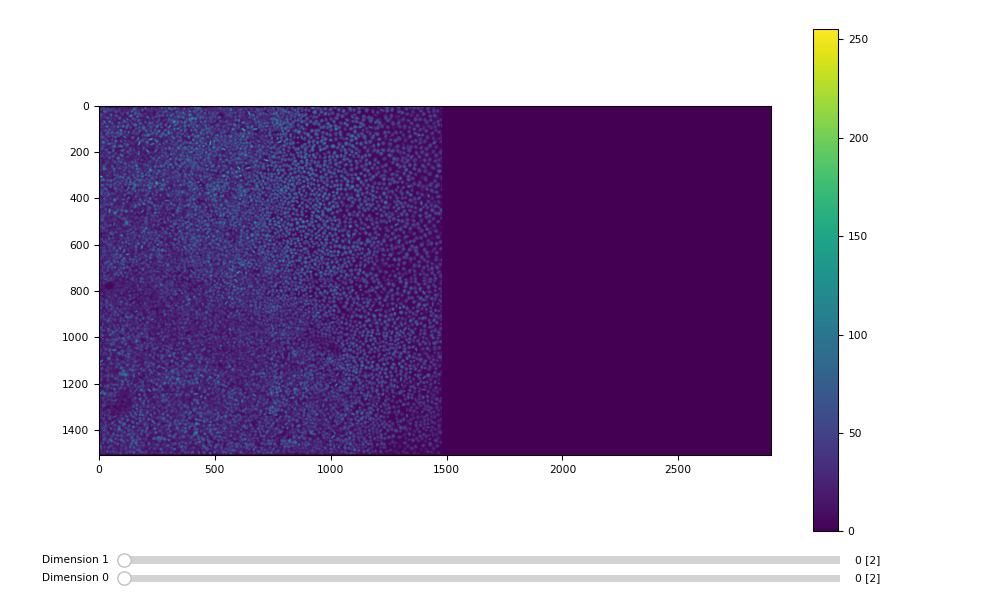

In [456]:
tifffile.imshow(np.array([imt2, imt]))

In [339]:
w_blending = np.array([get_sigmoidal_border_weights_ndim(i, 10) for i in ims])

/home/malbert/miniconda3/envs/mvregfus/lib/python3.9/site-packages/tifffile/tifffile.py:20494: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  pyplot.Slider(


(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7efe45875a60>)

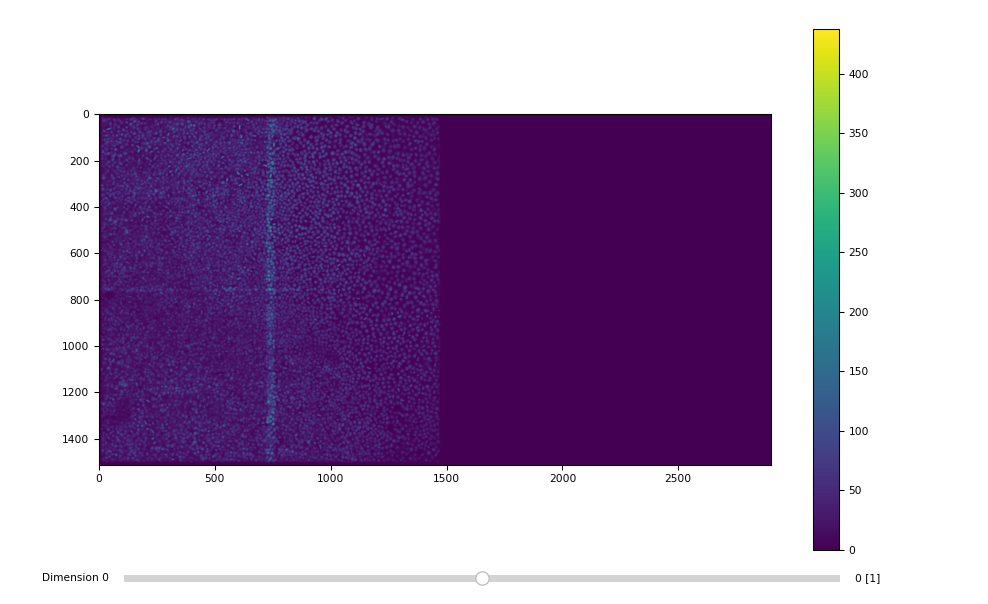

In [348]:
f = np.sum([w*im for w, im in zip(w_blending, ims)], axis=0)# / np.sum(w_blending, axis=0)
# ws = np.sum(w_blending, axis=0)
tifffile.imshow(f, photometric='la')

In [244]:
tifffile.imwrite('/home/malbert/Downloads/emb2_debug.tif', imss, imagej=True, metadata={'axes':'TZCYX', 'Labels': ['tp %s tile %s ch %s' %(t+1, tile, ch) for t in times[:3] for tile in [0,1,6,7] for ch in [0,1]]})


In [466]:
imd = np.array([imt2, imt])[:,0, 0].astype(np.uint16)

(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7efd4c97a790>)

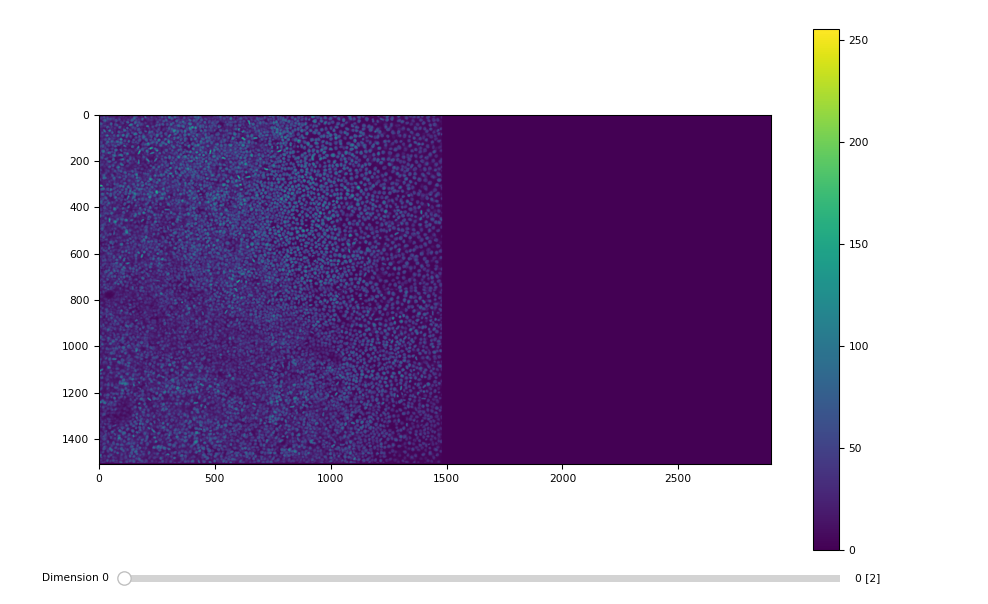

In [462]:
tifffile.imshow(imd)

In [464]:
imd.shape

(2, 1510, 2902)

In [467]:
tifffile.imwrite('/home/malbert/Downloads/emb2_blending_vs_mean_fusion.tif', imd, imagej=True, metadata={'axes':'CYX', 'Labels': ['winner-takes-it-all blending fusion', 'simple mean fusion']})


In [ ]:
tifffile.imwrite('/home/malbert/Downloads/emb2_debug.tif', imss, imagej=True, metadata={'axes':'TZCYX', 'Labels': ['tp %s tile %s ch %s' %(t+1, tile, ch) for t in times[:3] for tile in [0,1,6,7] for ch in [0,1]]})


In [198]:
[str(t) for t in times[:3] for ch in range(4)]

['65', '65', '65', '65', '66', '66', '66', '66', '67', '67', '67', '67']

In [2]:
%%capture

from mvregfus import mv_graph, io_utils, mv_utils

import importlib
mv_graph = importlib.reload(mv_graph)
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)
multiview = importlib.reload(multiview)

fn = files[0]

graph = {}
for t in range(1):

    px_overlap_between_stacks = 30

    # specify input views
    view_dict = dict()
    fp = '/home/malbert/projects/stitching/data/highmag/highmag_max_t%(t)03d_ch%(ch)s_%(tile)01d.tif'

    tiles = range(1, 9)

    # def tile_index_to_gridpos(iind):
    #     if iind <=2: return ((0, iind))
    #     elif iind <=5: return ((1, 5-iind))
    #     else: return ((2, iind-6))
    
    def tile_index_to_gridpos(iind):
        if iind <=3: return ((0, iind))
        else: return ((1, 3 - (iind - 4)))

    xy_shape = None
    for iind, tile in enumerate(tiles):
        view_dict[iind] = dict()
        view_dict[iind]['view'] = iind # view identifier
        view_dict[iind]['filename'] = fp %{'tile': tile, 't':t, 'ch':"%(ch)02d"}
        if xy_shape is None:
            xy_shape = np.array(tifffile.imread(fp %{'tile': tile, 't':t, 'ch':"00"}).shape)
            xy_shape = np.array(list(xy_shape))
            # xy_shape = np.array(io_utils.)
        view_dict[iind]['spacing'] = np.ones(2)
        view_dict[iind]['rotation'] = 0 # all tiles have same rotation angle
        view_dict[iind]['shape'] = xy_shape

        view_dict[iind]['origin'] = np.array(tile_index_to_gridpos(iind)) * \
                                    np.array(tuple(xy_shape[:])) \
                                    - 2 * np.array(tile_index_to_gridpos(iind)) * px_overlap_between_stacks

    pairs = [(ii,ij) for ii, i in enumerate(tiles)
             for ij, j in enumerate(tiles)
             if np.sum(np.abs(np.array(tile_index_to_gridpos(ii))-np.array(tile_index_to_gridpos(ij)))) == 1 and ii<ij]

    outdir = '/home/malbert/projects/stitching/data/highmag/out'

    # build dask graph
    graph.update(
        mvregfus.mv_graph.build_multiview_graph(
            out_dir=outdir,
            ndim=2,
            filepath=None,
            channels=[0],
            reg_channel=0,
            perform_chromatic_correction=False,
            mv_registration_bin_factors=[2, 2],
            mv_final_spacing=[1,1],
            pairs=pairs,
            view_dict=view_dict,
            fusion_method='weighted_average',
            fusion_weights='blending',
        #     fusion_weights='dct',
            elastix_dir='/home/malbert/software/elastix',
            pairwise_registration_mode=None, # 0: translation registration using elastix
            final_volume_mode='union',
            debug_pairwise_registration=True,
            background_level=0,
            sample=t,
            time_alignment=False,
            time_alignment_ref_view=0,
        )
    )

# compute dask graph
keys = [k for k in graph.keys() if k.startswith('mv_transf')]
# keys = [k for k in graph.keys() if k.startswith('view')]
# o = io_utils.get(graph, keys, local=True)
# graph
print(keys)

In [3]:
from dask.diagnostics import ProgressBar
# with ProgressBar():

import importlib

mv_utils = importlib.reload(mv_utils)
io_utils = importlib.reload(io_utils)

o = io_utils.get(graph, keys, local=False)

[[13 12 11 ... 24 16 15]
 [10 10 12 ... 32 28 23]
 [11 12 20 ... 37 29 31]
 ...
 [25 33 36 ... 17 36 42]
 [37 42 40 ... 15 25 40]
 [51 49 41 ... 10 16 25]]
[[15 18 24 ... 31 32 26]
 [12 15 20 ... 29 25 28]
 [14 20 19 ... 20 25 22]
 ...
 [14 13 14 ... 23 16 13]
 [14 12 15 ... 15 12 10]
 [17 15 21 ... 14 10 10]]
DECORATOR local... register_linear_elastix
producing /home/malbert/projects/stitching/data/highmag/out/mv_params_000_000_vfix000_vmov001.prealignment.h5
compute clahe with kernel size 10
compute clahe with kernel size 10
DECORATOR local... calc_stack_properties_from_views_and_params
[[51 38 20 ...  3  2  2]
 [45 46 41 ...  2  3  2]
 [46 51 53 ...  3  2  3]
 ...
 [22  8 10 ...  3  3  3]
 [18  7  9 ...  3  3  3]
 [13  5  7 ...  2  3  3]]
DECORATOR local... register_linear_elastix
producing /home/malbert/projects/stitching/data/highmag/out/mv_params_000_000_vfix001_vmov002.prealignment.h5
compute clahe with kernel size 10
compute clahe with kernel size 10
DECORATOR local... calc_sta

In [ ]:
imt = []
from tqdm import tqdm
import h5py
min_shape = np.array([50000, 50000])
chs = [0]
for t in tqdm(range(1)):
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in range(8)]
        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        tim.append(im)
        
    imt.append(np.array(tim))
    min_shape = np.min([min_shape, im.shape],0)
    
imt = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imt])

tifffile.imshow(imt, vmin=0, vmax=100)

In [4]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
a=

In [ ]:
rm -r /home/malbert/Downloads/stitching/mvregfus1_max

In [ ]:
ls /home/malbert/Downloads/stitching/mvregfus1

In [ ]:
# from mvregfus import mv_graph, io_utils, mv_utils

# import importlib
# mv_graph = importlib.reload(mv_graph)
# io_utils = importlib.reload(io_utils)
# mv_utils = importlib.reload(mv_utils)
# multiview = importlib.reload(multiview)

# n_tiles_per_dim = 5
# px_overlap_between_stacks = 30

# # specify input views
# view_dict = dict()
# # for iind, ind in enumerate(np.ndindex(x.numblocks)):
# fp = '/home/malbert/Downloads/stitching/emb_9/tif_planes/f_%(tile)01d_t%(t)03d_c%(ch)03d.tif'

# tiles = range(1, 9)

# def tile_index_to_gridpos(iind):
#     if iind <=3: return ((0, iind))
#     else: return ((1, 7-iind))

# xy_shape = None
# for iind, tile in enumerate(tiles):
#     view_dict[iind] = dict()
#     view_dict[iind]['view'] = iind # view identifier
#     view_dict[iind]['filename'] = fp %{'tile': tile, 't':1, 'ch':1}
#     if xy_shape is None:
#         xy_shape = np.array(tifffile.imread(view_dict[iind]['filename']).shape)
#         # xy_shape = np.array(io_utils.)
#     view_dict[iind]['spacing'] = np.ones(3)
#     view_dict[iind]['rotation'] = 0 # all tiles have same rotation angle
#     view_dict[iind]['shape'] = np.array((10,) + tuple(xy_shape))
    
#     view_dict[iind]['origin'] = np.array((0,)+tile_index_to_gridpos(iind)) * \
#                                 np.array((0,) + tuple(xy_shape)) \
#                                 - 2 * np.array((0,)+tile_index_to_gridpos(iind)) * px_overlap_between_stacks

# pairs = [(ii,ij) for ii, i in enumerate(tiles)
#          for ij, j in enumerate(tiles)
#          if np.sum(np.abs(np.array(tile_index_to_gridpos(ii))-np.array(tile_index_to_gridpos(ij)))) == 1]

# # pairs = pairs[:1]

# # build dask graph
# graph = mvregfus.mv_graph.build_multiview_graph(
#     out_dir='/home/malbert/Downloads/stitching/mvregfus1',
#     filepath=None,
#     channels=[0],
#     mv_registration_bin_factors=[1,1,1],
#     mv_final_spacing=[1,1,1],
#     pairs=pairs,
#     view_dict=view_dict,
#     fusion_method='weighted_average',
#     fusion_weights='blending',
# #     fusion_weights='dct',
#     elastix_dir='/home/malbert/software/elastix',
#     pairwise_registration_mode=0, # 0: translation registration using elastix
#     final_volume_mode='union',
#     debug_pairwise_registration=True,
#     background_level=0,
# )

# # compute dask graph
# o = io_utils.get(graph, mv_graph.multiview_fused_label %(0, 0, 0), local=True)
# # graph

In [ ]:
res = o.compute()#scheduler='single-threaded')

In [ ]:
%debug

In [ ]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
h5py.File('

In [ ]:
tifffile.imshow(res)

In [ ]:
1

(<Figure size 988.8x604.8 with 4 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f6bfcba50d0>)

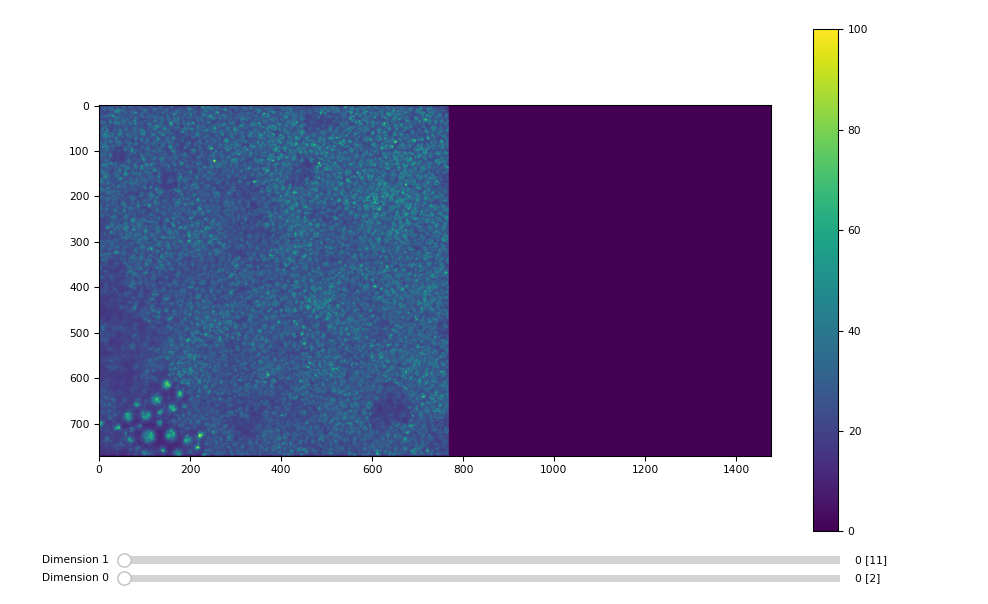

In [ ]:
import h5py
h5py.File('/home/malbert/projects/stitching/data/3d_mvregfus_2/mv_params_000_000_vfix000_vmov001.prealignment.h5')['prealignment'][()]
fns_tview = ['/home/malbert/projects/stitching/data/3d_mvregfus_2/mv_transf_view_000_000_v%03d_c02.image.ims' %v for v in range(2)]

ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])
tifffile.imshow(ims, vmin=0, vmax=100)

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fc2499b6b50>)

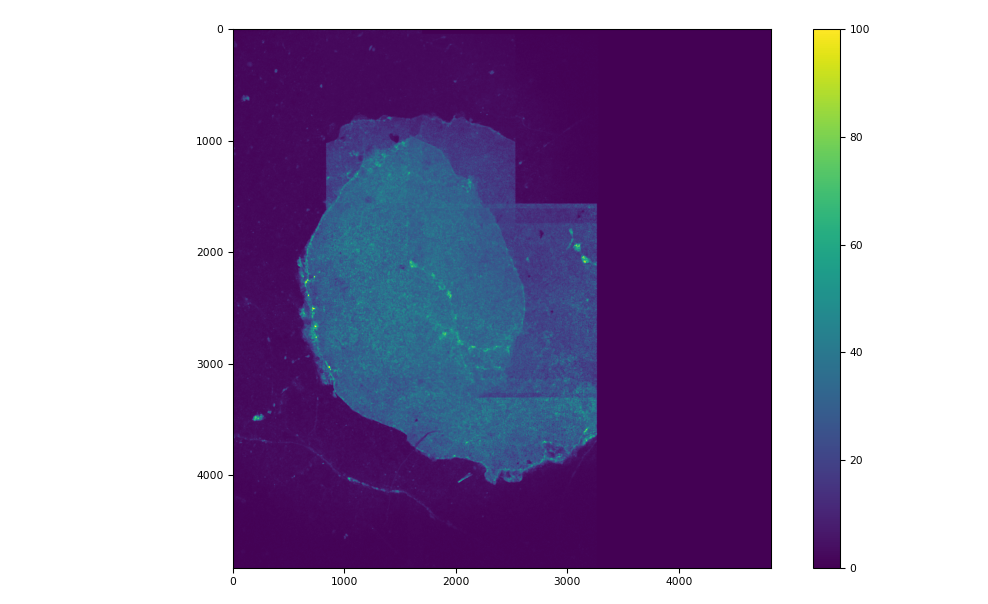

In [117]:
imt = []
from tqdm import tqdm
import h5py
min_shape = np.array([50000, 50000])
chs = [0]
for t in tqdm(range(1)):
    tim = []
    for ch in chs:
    
        fns_tview = [os.path.join(outdir, 'mv_transf_view_000_%03d_v%03d_c%02d.image.ims' %(t, v, ch)) for v in range(8)]
        ims = np.array([h5py.File(fn_tview, 'r')['Data'][()] for fn_tview in fns_tview])

        w = np.sum(ims!=0, 0)
        w[w==0]=1
        im = np.sum(ims, 0)/w
        tim.append(im)
        
    imt.append(np.array(tim))
    min_shape = np.min([min_shape, im.shape],0)
    
imt = np.array([i[:, :min_shape[0], :min_shape[1]] for i in imt])

tifffile.imshow(imt, vmin=0, vmax=100)

In [ ]:
tifffile.imsave("/home/malbert/projects/stitching/WT_emb2_20X_part1_Scene-2-TR3_mvregfus_ch_1_2.tif", imt)

/tmp/ipykernel_124126/2477530512.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("/home/malbert/projects/stitching/WT_emb2_20X_part1_Scene-2-TR3_mvregfus_ch_1_2.tif", imt)


In [ ]:
rm -r /home/malbert/Downloads/stitching/mvregfus1

In [ ]:
# load result from file
fused_result = io_utils.process_input_element(os.path.join('data/stitch', mv_graph.multiview_fused_label %(0, 0, 0)))

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(fused_result.max(-3), vmin=0, vmax=10000)
